In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Hand cleansed
Hand cleaned to removed duplicates

In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [3]:
cleansed.count().count()

123

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

Idea:

* Sort portfolios on an annual baisis
* cacluated $\sigma$, $\mu$, skew, max drawdown

* Need to creat panel data and start running regression on that.  

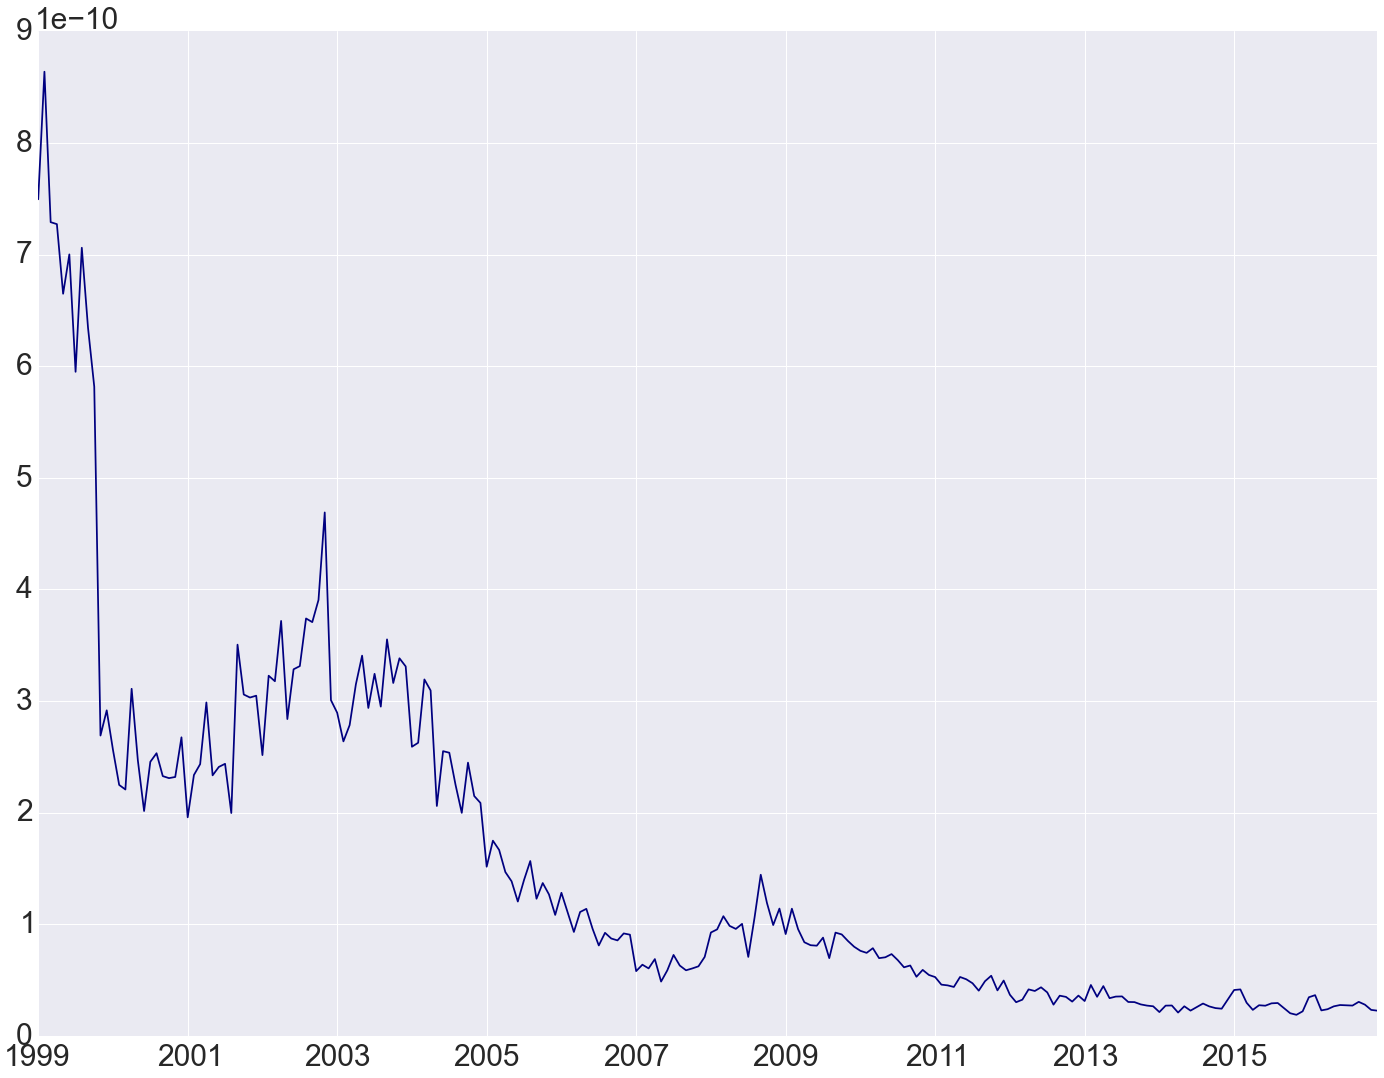

In [5]:
amihud.median(axis=1).dropna().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


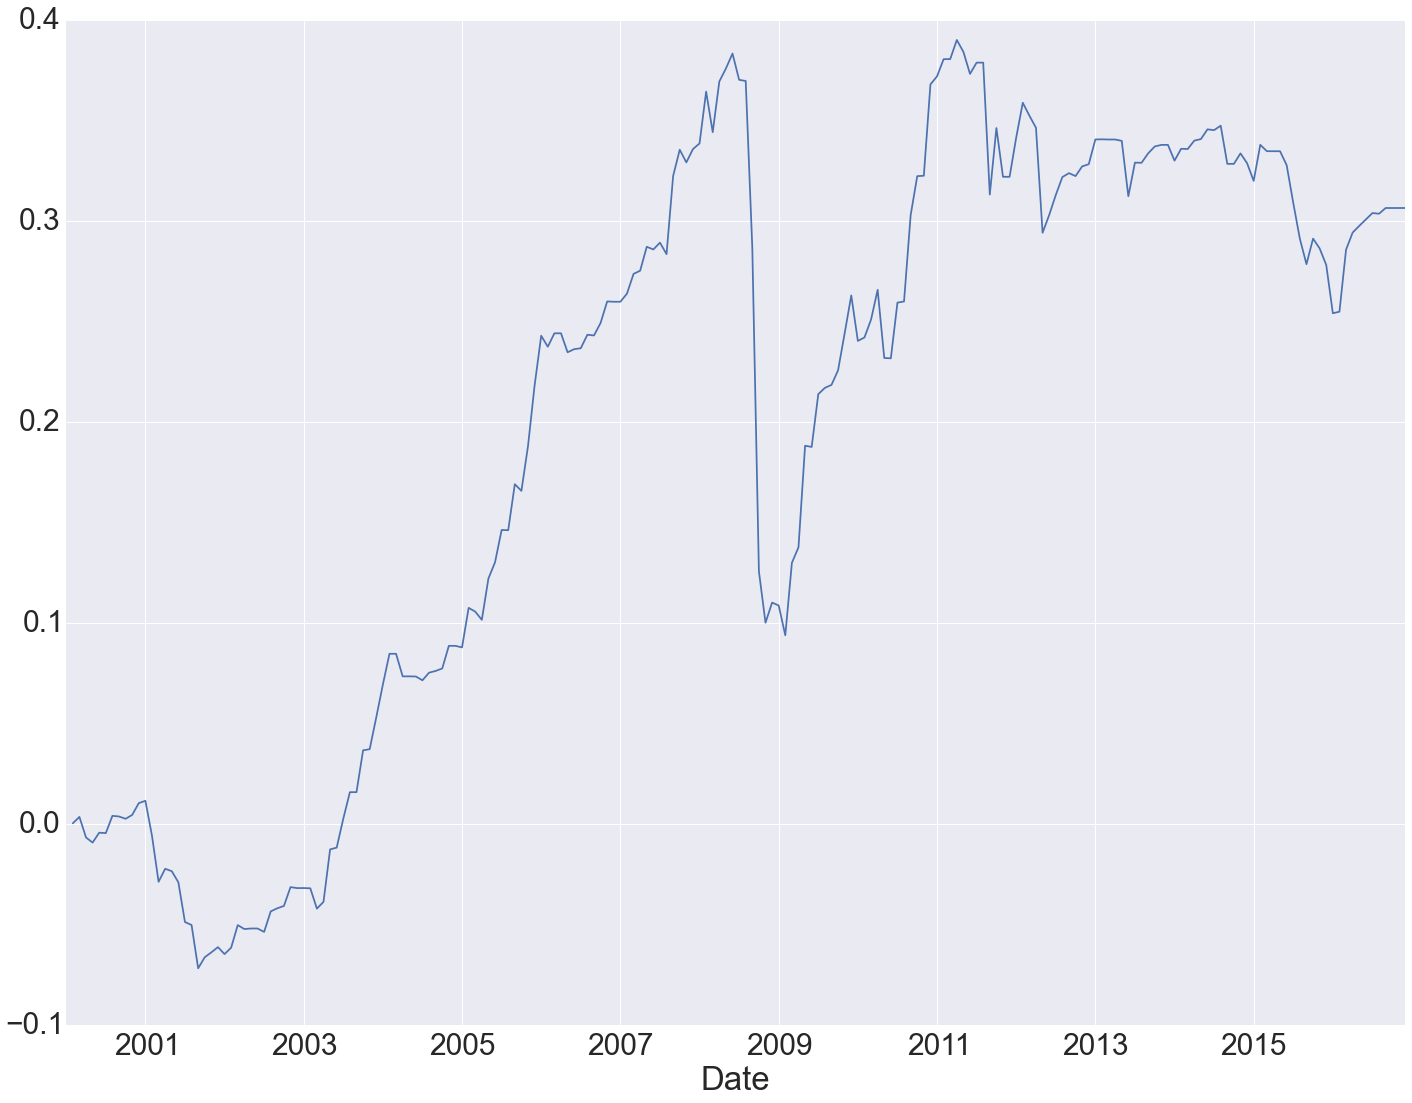

In [14]:
x=cleansed.resample(rule='m',how='last')['2000':'2016'].pct_change().median(axis=1)
x.cumsum().plot()


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=24).mean()
  if __name__ == '__main__':


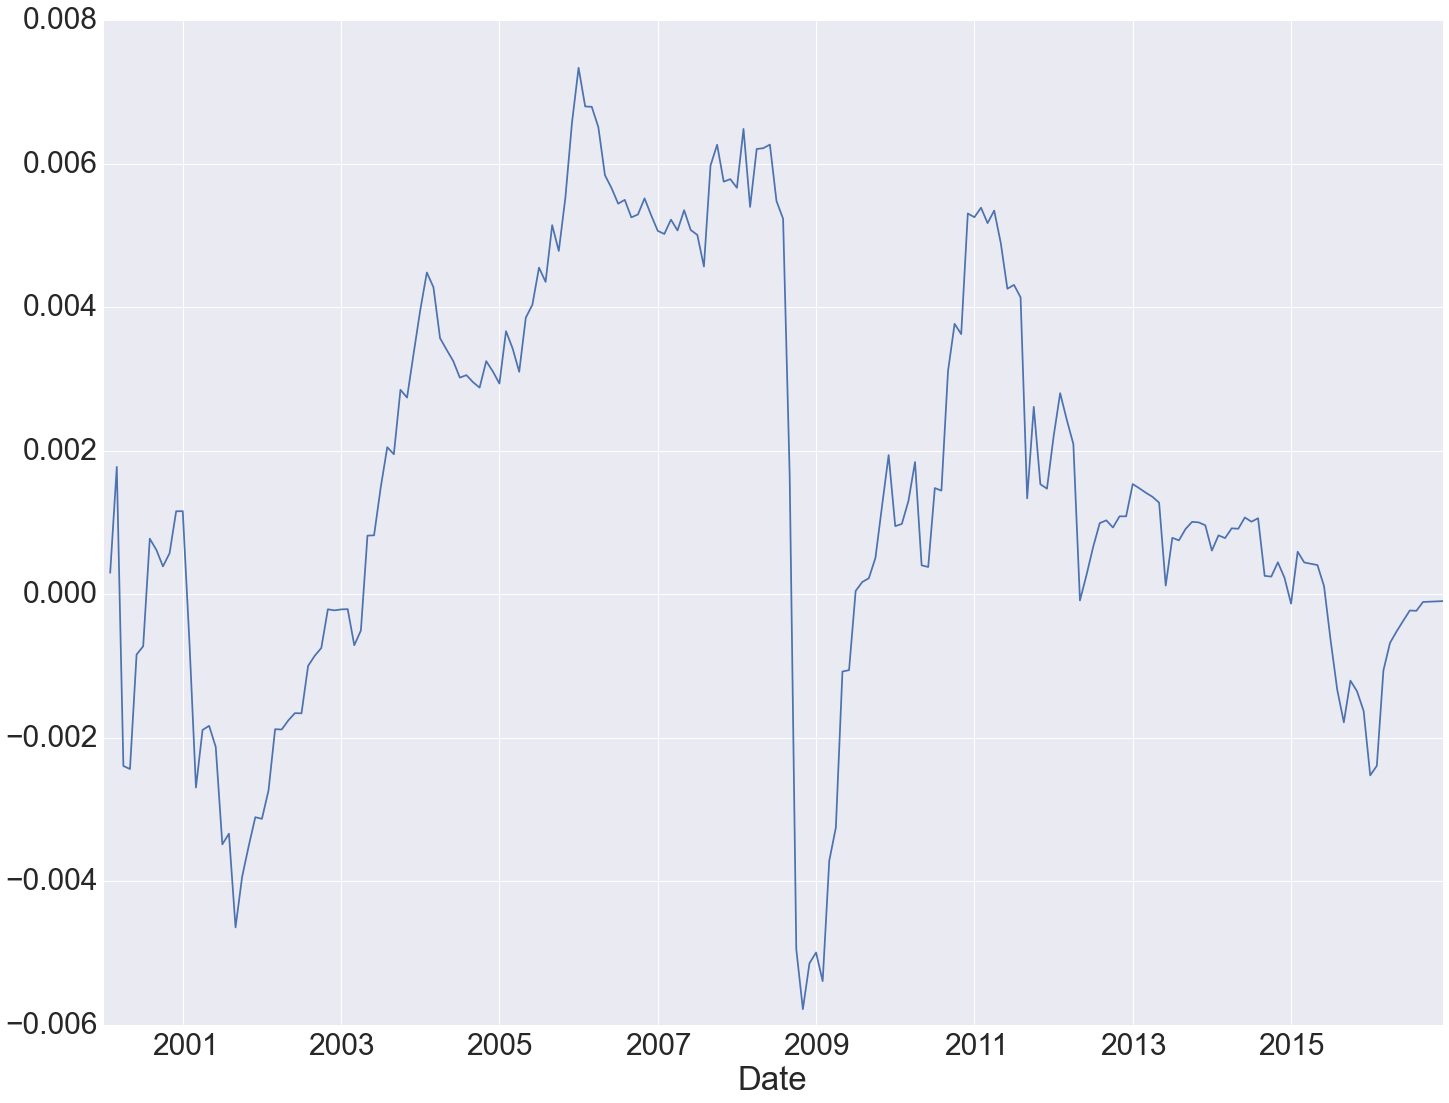

In [17]:
pd.ewma(x,24).plot()

In [42]:
cs_data=pd.read_csv('CS_AltBeta.csv',parse_dates=['Date'],index_col=[0])
cs_month=cs_data.dropna().resample(rule='m',how='sum')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  from IPython.kernel.zmq import kernelapp as app


In [49]:
med_rtn=x.dropna()
ind_res2 = pd.DataFrame()
for c in cs_month.columns:
    s=pd.Series()
    ind=cs_month[c].dropna()['2000-2':'2016'].index
    ex=pd.DataFrame()
    ex['Medium Return']=med_rtn[ind]
    ex['Intercept']=1
    res=sm.OLS(cs_month[c].dropna()[ind],ex).fit()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Medium Return']=res.params['Medium Return']
    s['Medium Return Tstat']=res.tvalues['Medium Return']
    s['Adj R^2']=res.rsquared_adj
    ind_res2[c]=s

In [50]:
ind_res2.round(2)

,Liquidity Alternative Beta Index,Event Driven Liquid Index,Global Strategies Liquid Index,Long/Short Liquid Index,Managed Futures Liquid Index,Merger Arbitrage Liquid Index
Intercept,0.00,0.01,0.00,0.00,0.02,0.00
Intercept Tstat,3.95,3.94,4.02,2.78,3.09,3.73
Medium Return,0.30,0.36,0.30,0.29,-0.08,0.13
Medium Return Tstat,5.41,5.04,5.64,3.56,-0.25,2.49
Adj R^2,0.12,0.11,0.13,0.05,-0.00,0.03


In [62]:
df=pd.DataFrame()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=24).mean()
  if __name__ == '__main__':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: pd.ewm_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=12).corr(other=<Series>)
  app.launch_new_instance()


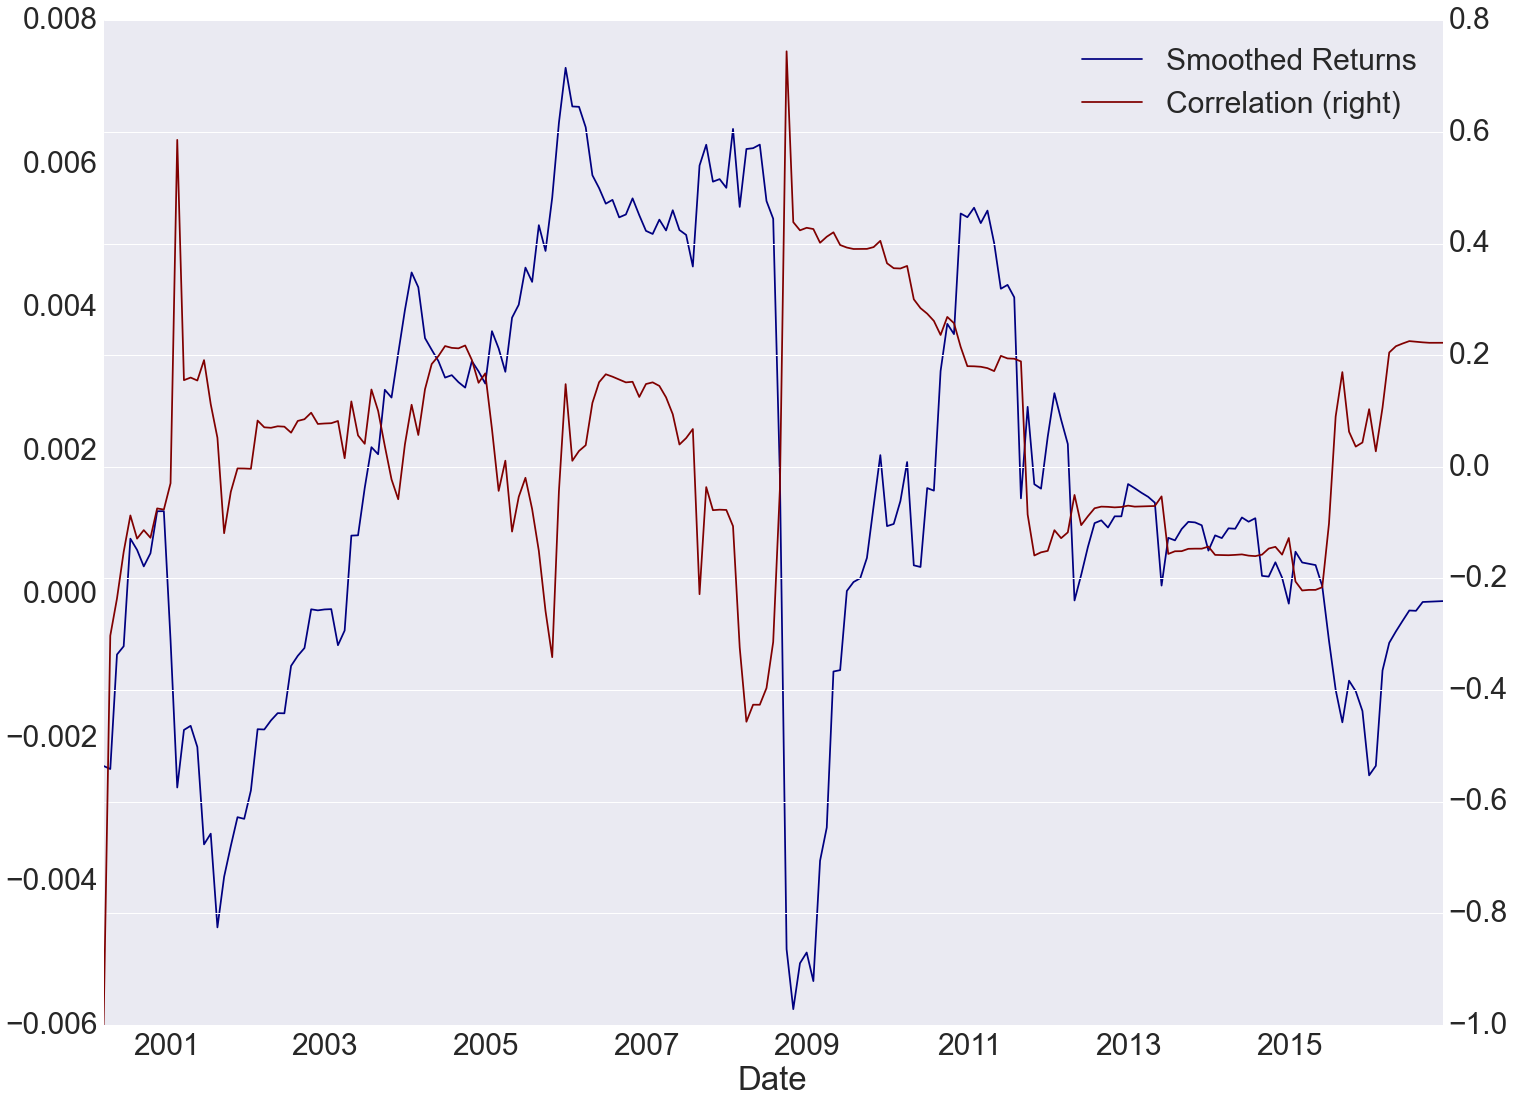

In [77]:
df['Smoothed Returns']=pd.ewma(x,24)
df['Returns']=x
df['Correlation']=pd.ewmcorr(x,x.shift(1),12).dropna()
df.dropna()[['Smoothed Returns','Correlation']].plot(colormap='jet',secondary_y='Correlation')

In [78]:
ind2=df.dropna().index
ind_res2 = pd.DataFrame()
for c in cs_month.columns:
    s=pd.Series()
    ind=cs_month[c].dropna()[ind2].index
    ex=pd.DataFrame()
    ex['Medium Return']=df.Returns[ind]
    ex['Correlation']=df.Correlation[ind]
    ex['Intercept']=1
    res=sm.OLS(cs_month[c].dropna()[ind],ex).fit()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Medium Return']=res.params['Medium Return']
    s['Medium Return Tstat']=res.tvalues['Medium Return']
    s['Correlation']=res.params.Correlation
    s['Correlation Tstat']=res.tvalues.Correlation
    s['Adj R^2']=res.rsquared_adj
    ind_res2[c]=s

In [79]:
ind_res2.round(2)

,Liquidity Alternative Beta Index,Event Driven Liquid Index,Global Strategies Liquid Index,Long/Short Liquid Index,Managed Futures Liquid Index,Merger Arbitrage Liquid Index
Intercept,0.00,0.01,0.00,0.00,0.02,0.00
Intercept Tstat,3.65,3.73,3.49,2.47,2.75,3.06
Medium Return,0.31,0.37,0.31,0.30,-0.08,0.14
Medium Return Tstat,5.89,5.22,6.02,3.84,-0.24,2.73
Correlation,0.01,0.01,0.01,0.01,0.01,0.01
Correlation Tstat,1.97,1.05,2.38,1.49,0.31,2.19
Adj R^2,0.15,0.11,0.16,0.07,-0.01,0.04


# Results 

* Not to helpful, because it mainly shows that the Lqiudity Alternative index and many others have some beta to global futures markets but that surely is known. 
* Managed futures has 0 both to correlation and to expected returns.  Basically Moskowitz et al is not true.